# Introduction

Short notebook to get an overview of model performance across architectures and dimensionality. 

In [ ]:
# colab setup:

!git clone https>

In [1]:
# general setup:
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


from NM_TinyRNN.code.models import parallelised_training as pat
from pathlib import Path
from importlib import reload

In [40]:
# you've trained a bunch of models with:

reload(pat)
#pat.run_training(overwrite=True)

#Here we append the evaluation performance to the model info dataframe

info_df = pat.get_train_info_df()
evals = []
seeds = []
for model_info in info_df.itertuples():
    model_dir = Path(model_info.save_path)
    eval_json_path = model_dir / f'{model_info.model_id}_info.json'
    if eval_json_path.exists():
        with open(eval_json_path, 'r') as f:
            eval_info = json.load(f)
        evals.append(eval_info['eval_pred_loss'])
    else:
        evals.append(np.nan)
info_df['eval_CE'] = evals
#open the json and extract eval performance for each model:

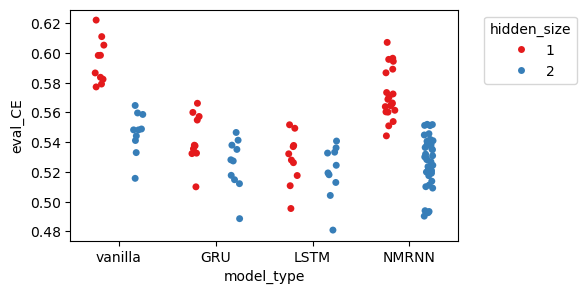

In [3]:
plt.figure(figsize=(5,3))
ax = sns.stripplot(
    data=info_df,  
    y='eval_CE', 
    x='model_type',
    hue='hidden_size',
    jitter=True,
    dodge=True, palette='Set1',
)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='hidden_size')
plt.show()

In [47]:
## Code to copy over the median-performing models for testing and comparisons

def closest_to_median(subdf):
    med = subdf["eval_CE"].median()
    idx = (subdf["eval_CE"] - med).abs().idxmin()
    return subdf.loc[idx, :]

median_df = info_df.groupby("model_id").apply(closest_to_median).reset_index(drop=True)
median_df

import os
import shutil
from pathlib import Path

def copy_median_models(df, example_path):
    """
    Copy median performing model files into EXAMPLE_PATH/<model_type>/.
    
    Parameters
    ----------
    df : pd.DataFrame
        Must contain columns ['save_path', 'model_type', 'model_ID'].
        save_path should be a pathlib.Path pointing to the model directory.
    example_path : str or Path
        Parent directory where copies will be stored.
    """
    example_path = Path(example_path)
    example_path.mkdir(parents=True, exist_ok=True)

    # files we want to copy for each model
    file_suffixes = [
        "_info.json",
        "_model_state.pth",
        "_training_losses.htsv",
        "_trials_data.htsv",
    ]
    
    for _, row in df.iterrows():
        save_path = Path(row["save_path"])
        model_type = row["model_type"]
        model_id = row["model_id"]

        # make sure destination subfolder exists
        dest_dir = example_path / model_type
        dest_dir.mkdir(parents=True, exist_ok=True)

        for suffix in file_suffixes:
            src = save_path / f"{model_id}{suffix}"
            dst = dest_dir / f"{model_id}{suffix}"
            if src.exists():
                shutil.copy(src, dst)
                print(f"Copied {src} → {dst}")
            else:
                print(f"Warning: {src} not found!")

# Example usage:
copy_median_models(median_df, Path('./NM_TinyRNN/data/rnns/example'))


/tmp/ipykernel_1132099/708382462.py:8: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  median_df = info_df.groupby("model_id").apply(closest_to_median).reset_index(drop=True)


Copied NM_TinyRNN/data/rnns/WS16/random_seed_3/GRU/1_unit_GRU_info.json → NM_TinyRNN/data/rnns/example/GRU/1_unit_GRU_info.json
Copied NM_TinyRNN/data/rnns/WS16/random_seed_3/GRU/1_unit_GRU_model_state.pth → NM_TinyRNN/data/rnns/example/GRU/1_unit_GRU_model_state.pth
Copied NM_TinyRNN/data/rnns/WS16/random_seed_3/GRU/1_unit_GRU_training_losses.htsv → NM_TinyRNN/data/rnns/example/GRU/1_unit_GRU_training_losses.htsv
Copied NM_TinyRNN/data/rnns/WS16/random_seed_3/GRU/1_unit_GRU_trials_data.htsv → NM_TinyRNN/data/rnns/example/GRU/1_unit_GRU_trials_data.htsv
Copied NM_TinyRNN/data/rnns/WS16/random_seed_3/LSTM/1_unit_LSTM_info.json → NM_TinyRNN/data/rnns/example/LSTM/1_unit_LSTM_info.json
Copied NM_TinyRNN/data/rnns/WS16/random_seed_3/LSTM/1_unit_LSTM_model_state.pth → NM_TinyRNN/data/rnns/example/LSTM/1_unit_LSTM_model_state.pth
Copied NM_TinyRNN/data/rnns/WS16/random_seed_3/LSTM/1_unit_LSTM_training_losses.htsv → NM_TinyRNN/data/rnns/example/LSTM/1_unit_LSTM_training_losses.htsv
Copied NM_

Index(['sparsity_lambda', 'epoch', 'val_pred_loss', 'train_pred_loss',
       'train_sparsity_loss'],
      dtype='object')


[None, None]

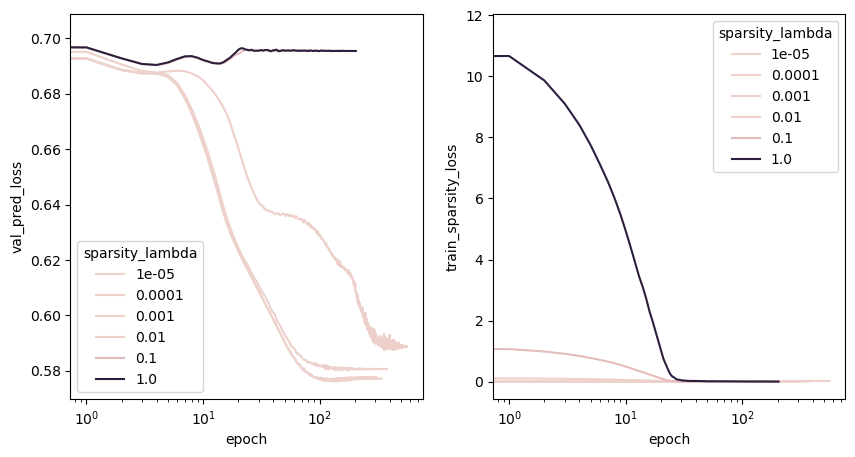

In [4]:
# inspect training losses for an example model (maybe the best one):
example = info_df.iloc[info_df.eval_CE.argmin()]
training_losses_df = pd.read_csv(Path(example.save_path) / f'{example.model_id}_training_losses.htsv', sep='\t')
print(training_losses_df.columns)
fig, ax = plt.subplots(1,2, figsize = (10,5))
sns.lineplot(training_losses_df, 
             x= 'epoch', 
             y='val_pred_loss',
             hue='sparsity_lambda', ax = ax[0])
sns.lineplot(training_losses_df, x = 'epoch',y='train_sparsity_loss', 
             hue = 'sparsity_lambda', ax=ax[1])
[x.set_xscale('log') for x in ax]